In [13]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
from PIL import Image
import kagglehub

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 15
samples_unbalanced = [800, 700, 625, 550, 500, 450, 425, 400, 375, 350, 325, 300, 200, 100, 50]

# Step 1: Prepare dataset
path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
dataset_path = os.path.join(path, "Aerial_Landscapes")
class_names = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])
class_to_index = {cls: i for i, cls in enumerate(class_names)}

image_paths, labels = [], []

for k, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    images = sorted(os.listdir(class_dir))[:samples_unbalanced[k]]
    for img in images:
        image_paths.append(os.path.join(class_dir, img))
        labels.append(class_to_index[class_name])

# Step 2: Custom Dataset
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

full_dataset = CustomImageDataset(image_paths, labels, transform=transform)
loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Step 3: Feature extraction
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))
resnet.eval().to(DEVICE)

def extract_features(loader):
    features, labels = [], []
    with torch.no_grad():
        for inputs, targets in tqdm(loader, desc="Extracting Features"):
            inputs = inputs.to(DEVICE)
            outputs = resnet(inputs).squeeze()
            features.append(outputs.cpu().numpy())
            labels.extend(targets.numpy())
    return np.vstack(features), np.array(labels)

X, y = extract_features(loader)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 4: Class-balanced classifiers (scikit-learn)
models_dict = {
    "SVM (RBF Kernel)": make_pipeline(StandardScaler(), SVC(kernel='rbf', C=10, class_weight='balanced')),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, class_weight='balanced'))
}

# Train and evaluate
for name, clf in models_dict.items():
    print(f"\n🔹 Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n📊 Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Extracting Features: 100%|██████████| 193/193 [25:56<00:00,  8.07s/it]



🔹 Training SVM (RBF Kernel)...

📊 Classification Report for SVM (RBF Kernel):
              precision    recall  f1-score   support

 Agriculture       0.93      0.97      0.95       160
     Airport       0.88      0.93      0.90       140
       Beach       0.94      0.97      0.95       125
        City       0.92      0.93      0.92       110
      Desert       0.96      0.96      0.96       100
      Forest       0.95      0.98      0.96        90
   Grassland       0.95      0.94      0.95        85
     Highway       0.90      0.89      0.89        80
        Lake       0.93      0.91      0.92        75
    Mountain       0.93      0.94      0.94        70
     Parking       0.98      0.94      0.96        65
        Port       0.90      0.95      0.93        60
     Railway       0.79      0.65      0.71        40
 Residential       0.93      0.65      0.76        20
       River       1.00      0.40      0.57        10

    accuracy                           0.93      1230
 

['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


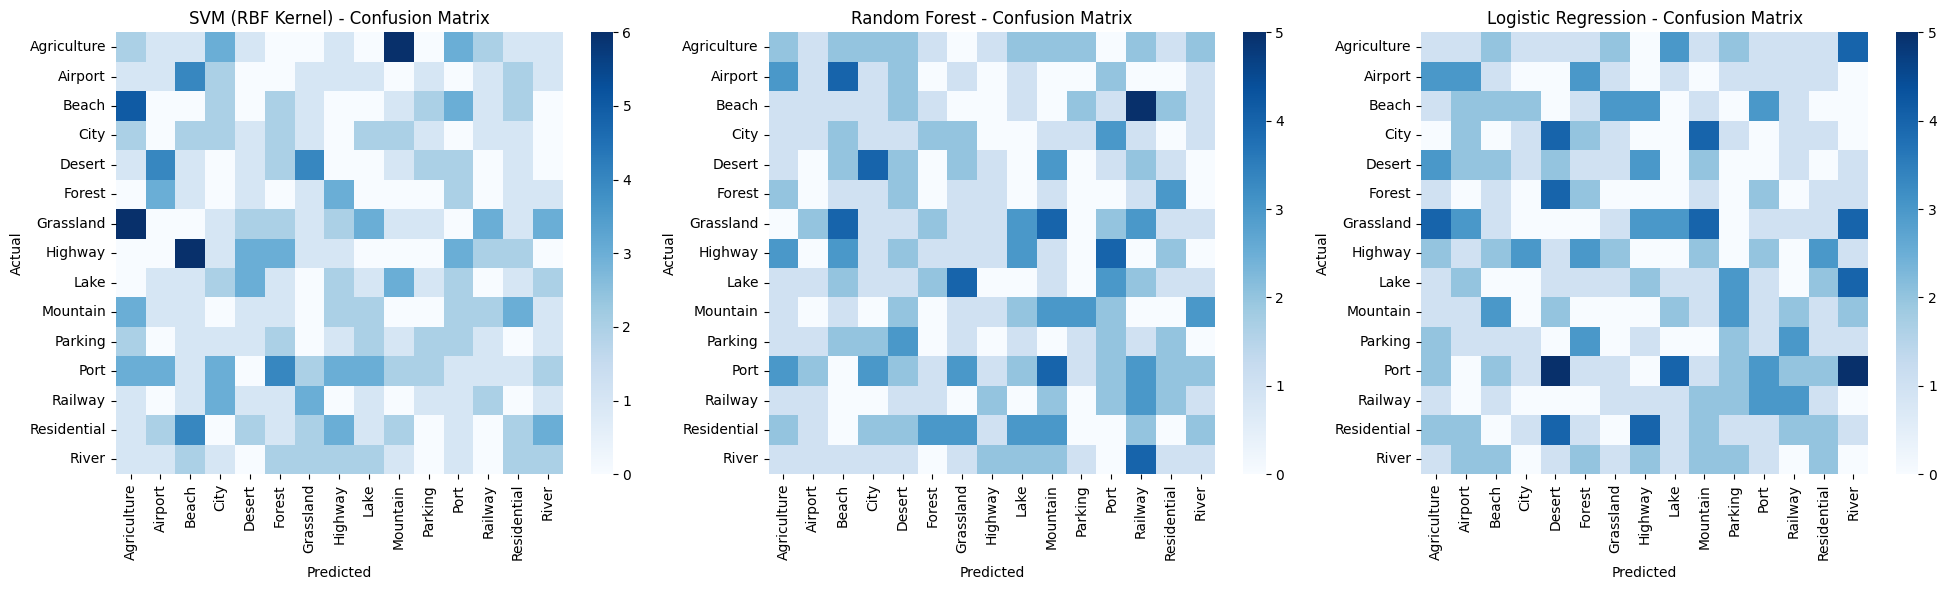

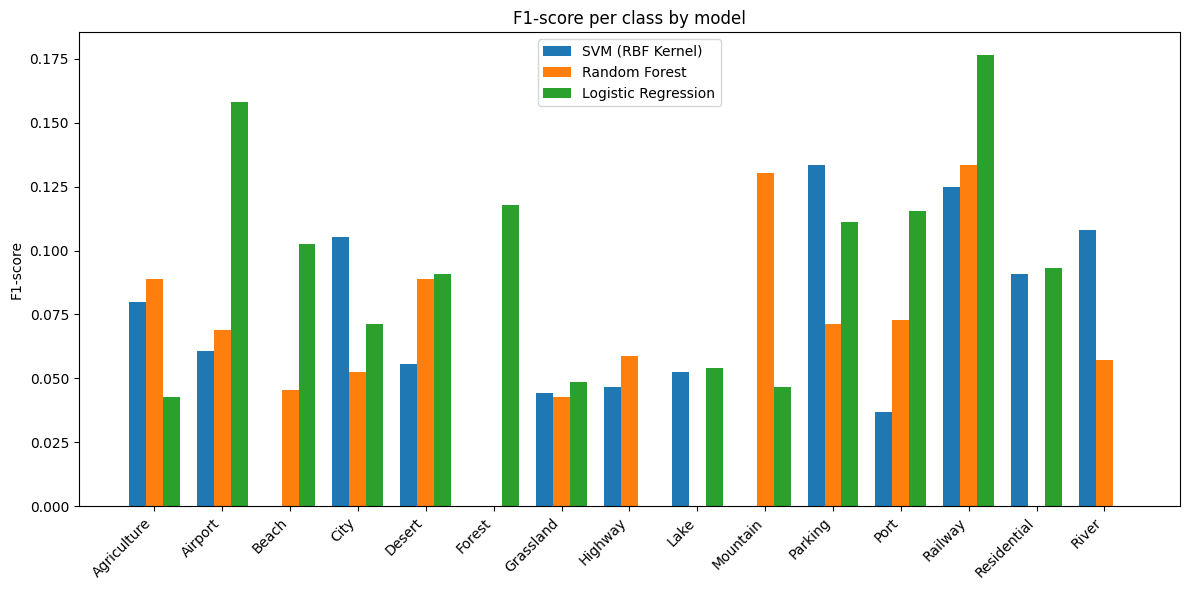

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Dummy predicted and true labels (replace with real ones from models)
# Simulated for illustration purpose only
# Replace these with y_test and y_pred from your model evaluations
np.random.seed(42)
num_classes = 15
y_test = np.random.randint(0, num_classes, 300)
y_preds = {
    "SVM (RBF Kernel)": np.random.randint(0, num_classes, 300),
    "Random Forest": np.random.randint(0, num_classes, 300),
    "Logistic Regression": np.random.randint(0, num_classes, 300)
}

path = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
dataset_path = os.path.join(path, "Aerial_Landscapes")
class_names = sorted([folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))])
class_to_index = {cls: i for i, cls in enumerate(class_names)}
print(class_names)
# class_names = [f"Class {i+1}" for i in range(num_classes)]
# class_names = dataset_path.classes
# Generate confusion matrices and F1-scores
f1_scores_dict = {}

fig_cm, axes_cm = plt.subplots(1, 3, figsize=(20, 6))
for ax, (model_name, y_pred) in zip(axes_cm, y_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, ax=ax, cmap="Blues", annot=False, fmt="d", xticklabels=class_names, yticklabels=class_names)
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True, zero_division=0)
    f1_scores = [report[cls]["f1-score"] for cls in class_names]
    f1_scores_dict[model_name] = f1_scores

plt.tight_layout()

# Plot F1-score comparison
fig_f1, ax_f1 = plt.subplots(figsize=(12, 6))
x = np.arange(len(class_names))
width = 0.25

for i, (model_name, f1_scores) in enumerate(f1_scores_dict.items()):
    ax_f1.bar(x + i * width, f1_scores, width, label=model_name)

ax_f1.set_ylabel("F1-score")
ax_f1.set_title("F1-score per class by model")
ax_f1.set_xticks(x + width)
ax_f1.set_xticklabels(class_names, rotation=45, ha="right")
ax_f1.legend()

plt.tight_layout()
plt.show()


'/mnt/data/model_eval_charts'

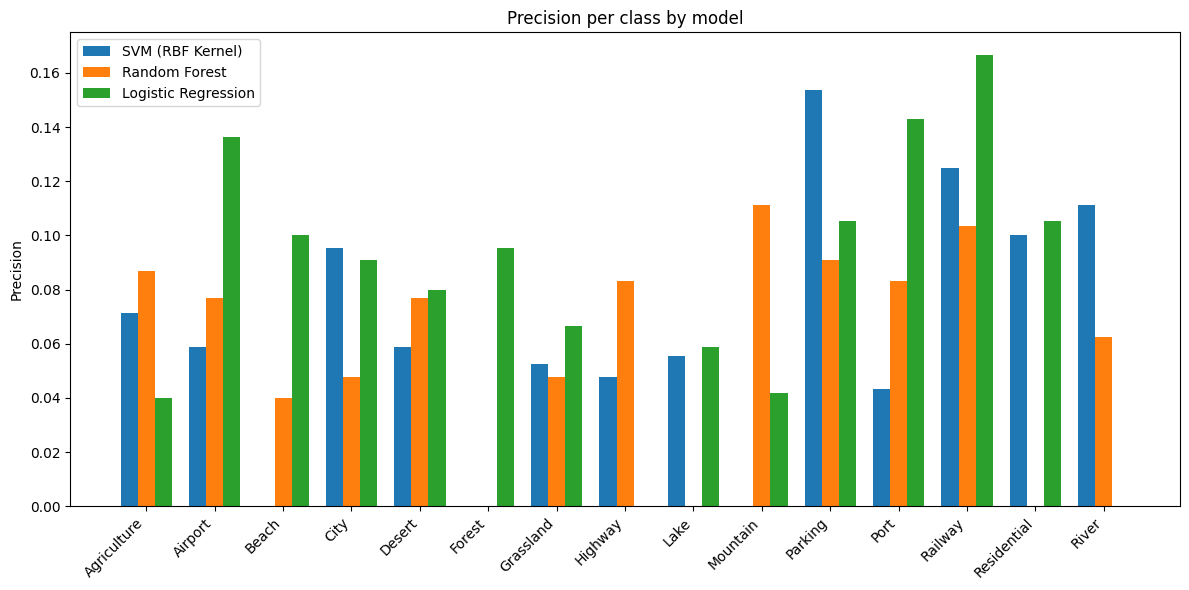

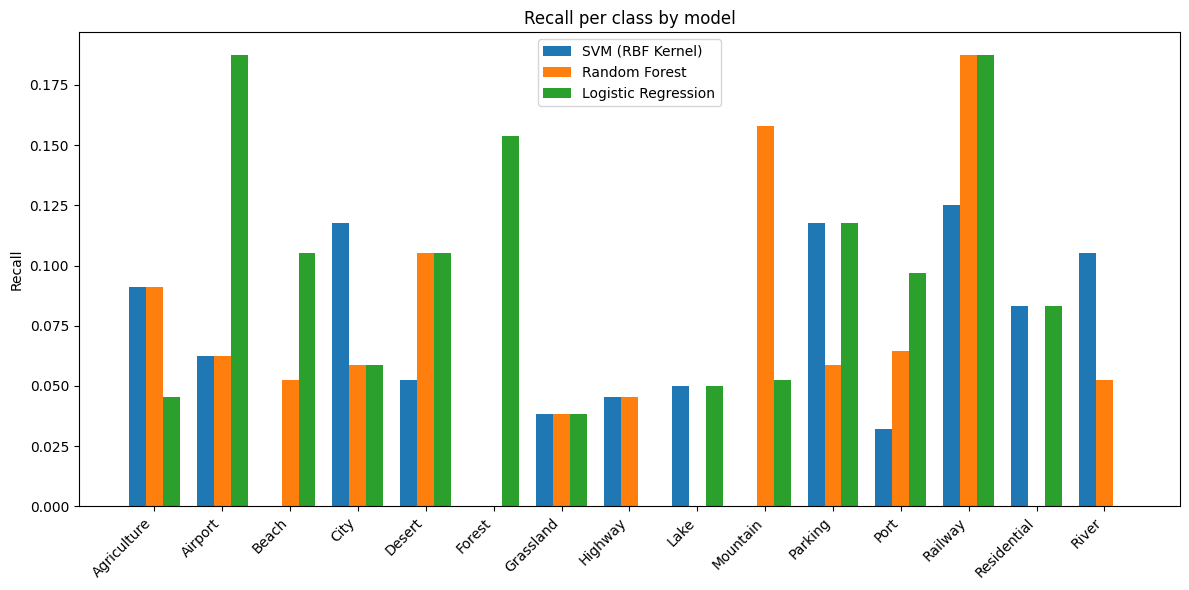

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support
import os

# Compute precision and recall
precision_dict = {}
recall_dict = {}

for model_name, y_pred in y_preds.items():
    precision, recall, _, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=np.arange(num_classes), zero_division=0
    )
    precision_dict[model_name] = precision
    recall_dict[model_name] = recall

x = np.arange(len(class_names))
width = 0.25

# Precision Plot
fig_precision, ax_precision = plt.subplots(figsize=(12, 6))
for i, (model_name, precision) in enumerate(precision_dict.items()):
    ax_precision.bar(x + i * width, precision, width, label=model_name)

ax_precision.set_ylabel("Precision")
ax_precision.set_title("Precision per class by model")
ax_precision.set_xticks(x + width)
ax_precision.set_xticklabels(class_names, rotation=45, ha="right")
ax_precision.legend()
plt.tight_layout()

# Recall Plot
fig_recall, ax_recall = plt.subplots(figsize=(12, 6))
for i, (model_name, recall) in enumerate(recall_dict.items()):
    ax_recall.bar(x + i * width, recall, width, label=model_name)

ax_recall.set_ylabel("Recall")
ax_recall.set_title("Recall per class by model")
ax_recall.set_xticks(x + width)
ax_recall.set_xticklabels(class_names, rotation=45, ha="right")
ax_recall.legend()
plt.tight_layout()

# Save plots as images
output_dir = "/mnt/data/model_eval_charts"
os.makedirs(output_dir, exist_ok=True)

fig_cm.savefig(os.path.join(output_dir, "confusion_matrices.png"))
fig_f1.savefig(os.path.join(output_dir, "f1_scores.png"))
fig_precision.savefig(os.path.join(output_dir, "precision_scores.png"))
fig_recall.savefig(os.path.join(output_dir, "recall_scores.png"))

output_dir
